## Dataset loading

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from utils import data

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    #"device": torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"),
}
pd.set_option("display.max_columns", None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

#load dfs
dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    #this featurization takes a long time so load it instead.
    df = data.featurize_data(
        df,load_existing_df=True, 
        pkl_path = os.path.join(dataset_path, 
                                f"./df_data_{file[:2]}.pkl")
    )
    df.name = file[:2]
    dfs[df.name] = df

## Model definition

Model are defined manually here using only a single feature: Fe composition without using the surrogate class. The model is also defined without input transform to ensure element fraction normalization because we want to calculate Ts and Bs values for elemental Fe. Absence other features, uncertainty is expected to be high.

In [2]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import trainGP

models = []

outcome_transform1 = Standardize(m=1)
outcome_transform2 = Standardize(m=1)

model_Bs = SingleTaskGP(
    torch.tensor(dfs['Bs']['Fe'].values).unsqueeze(dim=1), 
    torch.tensor(dfs['Bs']['Bs (T)'].values).unsqueeze(dim=1),
    #no input transform here
    outcome_transform=outcome_transform1,
    covar_module=ScaleKernel(RBFKernel()),
    )

model_Tc = SingleTaskGP(
    torch.tensor(dfs['Tc']['Fe'].values).unsqueeze(dim=1),
    torch.tensor(dfs['Tc']['Tc (K)'].values).unsqueeze(dim=1),
    #no input transform here
    outcome_transform=outcome_transform2,
    covar_module=ScaleKernel(RBFKernel()),
    )

models = [model_Bs, model_Tc]

for model in models:
    model.train()
    trainGP(model, lr=3e-2)

Epoch  50/200 - Loss: 1.288 noise: 0.689
Epoch 100/200 - Loss: 1.118 noise: 0.476
Epoch 150/200 - Loss: 1.107 noise: 0.471
Epoch 200/200 - Loss: 1.100 noise: 0.459
-------------------
Epoch  50/200 - Loss: 1.347 noise: 0.705
Epoch 100/200 - Loss: 1.280 noise: 0.647
Epoch 150/200 - Loss: 1.279 noise: 0.633
Epoch 200/200 - Loss: 1.214 noise: 0.521
-------------------


## Manual inference 
Infer along Fe composition grid. with help from the evaluateGP utility function. Mean and sigma are returned. 

In [3]:
from utils.model import evaluateGP

predicted_Tc = []
predicted_Tc_sigma = []

predicted_Bs = []
predicted_Bs_sigma = []

#explore Fe composition from 0 to 1
Fe_grid = np.linspace(0,1,101)

#infer
for Fe in Fe_grid:
    X = torch.tensor([Fe], **tkwargs).unsqueeze(0)
    mean, sem = evaluateGP(model_Bs,X)
    predicted_Bs.append(mean)
    predicted_Bs_sigma.append(sem)
for Fe in Fe_grid:
    X = torch.tensor([Fe], **tkwargs).unsqueeze(0)
    mean, sem = evaluateGP(model_Tc,X)
    predicted_Tc.append(mean)
    predicted_Tc_sigma.append(sem)

predicted_Tc = np.array(predicted_Tc)
predicted_Tc_sigma = np.array(predicted_Tc_sigma)

predicted_Bs = np.array(predicted_Bs)
predicted_Bs_sigma = np.array(predicted_Bs_sigma)

/Users/ktrerayapiwat/Software/Fe_alloy_phaseshift/utils/model.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, **tkwargs))


## Plot results

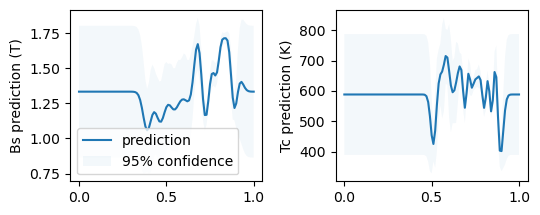

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=[5.5,2.25])

axes[0].plot(Fe_grid,predicted_Bs, label = 'prediction')
axes[0].fill_between(Fe_grid, 
                 predicted_Bs-2*predicted_Bs_sigma, 
                 predicted_Bs+2*predicted_Bs_sigma,
                 alpha = 0.05, label = '95% confidence')
axes[0].set_ylabel('Bs prediction (T)')
#axes[1].legend(loc='upper left')

axes[1].plot(Fe_grid,predicted_Tc, label = 'prediction')
axes[1].fill_between(Fe_grid, 
                 predicted_Tc-2*predicted_Tc_sigma, 
                 predicted_Tc+2*predicted_Tc_sigma,
                 alpha = 0.05, label = '95% confidence')
axes[1].set_ylabel('Tc prediction (K)')
axes[0].legend(loc='lower left')
fig.tight_layout()
fig.savefig('./imgs/elemental_Fe_inference.png', dpi=300)

In [7]:
print(f"Tc prediction at elemental Fe = {predicted_Tc[-1]:.02f}",
      "±", f"{2*predicted_Tc_sigma[-1]:.02f} K")

print(f"Bs prediction at elemental Fe = {predicted_Bs[-1]:.02f}",
      "±", f"{2*predicted_Bs_sigma[-1]:.02f} T")

Tc prediction at elemental Fe = 588.45 ± 199.48 K
Bs prediction at elemental Fe = 1.33 ± 0.47 T
